In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from helper import powerset

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
with open('mappings.json', 'r') as f:
    mappings = json.load(f)

# mappings = {re.sub('[^A-Za-z0-9]+$', '', k): v for k, v in mappings.items()}

with open('wave1_vars.json', 'r') as f:
    dict1 = json.load(f)

with open('wave2_vars.json', 'r') as f:
    dict2 = json.load(f)

In [3]:
df_C1W1nonet = pd.read_csv('C1W1_nonnetwork.csv')
df_C1W2nonet = pd.read_csv('C1W2_nonnetwork.csv')
df_C1W1net = pd.read_csv('C1W1_network.csv')

Remove irrelevant/insignificant variables

- IDs of participants/interviewers
- Text variables
- Multiple choices (DA7a-d, DA8a-d)

In [4]:
df_C1W1nonet = df_C1W1nonet.drop(columns=['PID','PID2','ID13','ID14','ND13','ND15',
                            'DA7a','DA7a_11_TEXT','DA7b','DA7b_11_TEXT','DA7c','DA7c_13_TEXT','DA7d','DA7d_11_TEXT',
                            'DA8a','DA8a_13_TEXT','DA8b','DA8b_11_TEXT','DA8c','DA8c_11_TEXT','DA8d','DA8d_11_TEXT',
                            'DM12_6_TEXT'])
df_C1W2nonet = df_C1W2nonet.drop(columns=['PID','PID2','Interviewer_ID','Q50','Q51','Q81','Q84',
                                        'Q103_R11_Other','Q105_R11_Other','Q207_R5','Q208_R4'])

All substances (4 main groups):

- Tobacco
- Alcohol
- Injection drug
    - heroin
    - prescription opioids
    - methamphetamine
    - cocaine
    - heroin and cocaine speedball
    - heroin and methamphetamine speedball
    - crack cocaine
    - buprenorphine
- Non-injection drug
    - marijuana
    - cocaine
    - Ecstasy/MDMA
    - PCP/angel dust
    - amphetamines
    - methamphetamine
    - barbiturates
    - benzodiazepines
    - opiates/opioids
    - heroin

### Missing Data Imputation

Note that below blocks only impute MNAR data, MAR data is manually imputed beforehand.

If variable type is (pure) numerical, impute using the mean of corresponding column.

In [5]:
vars_num = ['SC1','DM1']  # all numerical variables in W1

for v in vars_num:
    col = df_C1W1nonet[v]
    df_C1W1nonet[v] = col.fillna(col.mean())

If variable type is mixed (e.g., age first did sth, or never, or don't know), convert into pure categorical:

[0: 0-14 years old; 1: 15-24; 2: 25-64; 3: >=65; 4: never; 5: don't know]

In [6]:
vars_mixed = ['TB2','TB6','TB10','AL1','AL2','AL3','ID2','ND2']

for v in vars_mixed:
    col = df_C1W1nonet[v]
    for idx, i in enumerate(col):
        if 0 <= i <= 14:    df_C1W1nonet.at[idx, v] = 0  # children
        elif 15 <= i <= 24: df_C1W1nonet.at[idx, v] = 1  # youth
        elif 25 <= i <= 64: df_C1W1nonet.at[idx, v] = 2  # adult
        elif i >= 65:       df_C1W1nonet.at[idx, v] = 3  # senior
        elif i == -1:       df_C1W1nonet.at[idx, v] = 4  # never
        elif i == -2:       df_C1W1nonet.at[idx, v] = 5  # don't know

If variable type is categorical/binary, impute using the most frequent value of corresponding column.

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(df_C1W1nonet, y, test_size = 0.30)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(df_C1W1nonet)
X_imp = imp.transform(df_C1W1nonet)

In [21]:
print(X_imp.shape)
print(f'Any nan left? {np.isnan(X_imp).any()}')

(35, 176)
Any nan left? False


### Grouping Features

In [40]:
f_dict = {}
fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
for g in fgroups:
    features = [c for c in df_C1W1nonet if c.startswith(g)]
    f_indices = [df_C1W1nonet.columns.get_loc(c) for c in df_C1W1nonet if c.startswith(g)]  # column indices of the group's features
    f_dict[g] = f_indices
    print(f'{g} ({len(features)}): {features}')

SC (8): ['SC1', 'SC3', 'SC4', 'SC5', 'SC6', 'SC8', 'SC9', 'SC13']
DM (10): ['DM1', 'DM8', 'DM9', 'DM10', 'DM12', 'DM13', 'DM14', 'DM15', 'DM17', 'DM23']
TB (12): ['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'TB11', 'TB12']
AL (6): ['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6']
ID (18): ['ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7', 'ID8', 'ID9', 'ID10', 'ID11', 'ID12', 'ID15', 'ID16', 'ID17', 'ID18', 'ID19', 'ID20']
ND (12): ['ND1', 'ND2', 'ND3', 'ND4', 'ND5', 'ND6', 'ND7', 'ND8', 'ND9', 'ND10', 'ND11', 'ND12']
DA (56): ['DA1_1', 'DA1_2', 'DA1_3', 'DA1_4', 'DA1_5', 'DA1_6', 'DA1_7', 'DA2_1', 'DA2_2', 'DA2_3', 'DA2_4', 'DA2_5', 'DA2_6', 'DA2_7', 'DA5_R1', 'DA5_R2', 'DA5_R3', 'DA5_R4', 'DA5_R5', 'DA6_R1', 'DA6_R2', 'DA6_R3', 'DA6_R4', 'DA6_R5', 'DA7_R1', 'DA7_R2', 'DA7_R3', 'DA7_R4', 'DA7_R5', "DA7'_R1", "DA7'_R2", "DA7'_R3", "DA7'_R4", "DA7'_R5", "DA7'_R6", "DA7'_R7", "DA7'_R8", "DA7'_R9", "DA7'_R10", "DA7'_R11", 'DA8_R1', 'DA8_R2', 'DA8_R3', 'DA8_R4', 'DA8_R5'

Example: access feature group 'AL' directly from X_imp (2D array)

In [49]:
print(X_imp[:,f_dict['AL']].shape)
X_imp[:,f_dict['AL']]

(35, 6)


array([[1., 1., 1., 1., 4., 3.],
       [0., 1., 1., 1., 3., 1.],
       [1., 1., 2., 1., 7., 3.],
       [0., 1., 1., 1., 4., 2.],
       [1., 1., 1., 1., 5., 5.],
       [1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 7., 5.],
       [5., 5., 5., 1., 7., 0.],
       [4., 4., 4., 0., 0., 0.],
       [4., 4., 4., 0., 0., 0.],
       [0., 1., 2., 1., 7., 6.],
       [0., 0., 0., 1., 4., 5.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 2., 1., 0., 0.],
       [1., 1., 1., 1., 4., 0.],
       [1., 1., 1., 1., 4., 2.],
       [0., 1., 0., 1., 6., 5.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 6., 6.],
       [1., 1., 1., 1., 7., 0.],
       [1., 1., 5., 1., 1., 0.],
       [1., 5., 2., 1., 1., 0.],
       [1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 5., 1.],
       [1., 1., 1., 1., 7., 5.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 7., 4.],
       [1., 1., 1., 1., 6., 6.],
       [1.

Example: access list of feature groups ['AL', 'ID'] directly from X_imp (2D array)

In [84]:
fsubsets = ['AL', 'ID']
def get_f_indices(fsubsets):  # concatenate multiple feature groups (lists) into one big list of features
    return [f for fgroup in [f_dict[s] for s in fsubsets] for f in fgroup]

X_imp[:,get_f_indices(fsubsets)]

array([[ 1.,  1.,  1.,  1.,  4.,  3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1.,  1.,  1.,  3.,  1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  2.,  1.,  7.,  3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1.,  1.,  1.,  4.,  2.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  5.,  5.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1.,  1.,  1.,  7.,  5.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 5.,  5.,  5.,  1.,  7.,  0.,  0.

### Labeling

Binary labels indicating whether participants use more or less of each substance in wave 2 compared to wave 1

In [9]:
y_tobacco = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1])
y_alcohol = np.array([1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1])
y_inj =     np.array([0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0])
y_noninj =  np.array([0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0])
y_all = {'tobacco': y_tobacco, 'alcohol': y_alcohol, 'injection': y_inj, 'non-injection': y_noninj}

def calc_bm(y):
    return 1 - np.sum(y)/len(y)

# if we classify everyone into the majority negative class (0), what is the accuracy?
print(f'benchmark: tobacco = {calc_bm(y_tobacco)}, alcohol = {calc_bm(y_alcohol)}, inj = {calc_bm(y_inj)}, noninj = {calc_bm(y_noninj)}')

benchmark: tobacco = 0.7142857142857143, alcohol = 0.5142857142857142, inj = 0.7142857142857143, noninj = 0.6


### Training

In [10]:
loo = LeaveOneOut()
loo.get_n_splits(X_imp)

35

In [11]:
def loocv(X, y, model):
    scores = []
    for train_index, test_index in loo.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        # print(score)
        scores.append(score)

    return np.mean(scores)

#### Logistic Regression

In [45]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'newton-cg', 'lbfgs']

param_grid = dict(penalty=penalty, C=C, solver=solver)
grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced'),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=LeaveOneOut())

Change in tobacco use

In [46]:
grid_TB = grid
grid_TB.fit(X_imp, y_tobacco)

print(grid_TB.best_score_)
print(grid_TB.best_params_)

0.8285714285714286
{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
560 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447,

In [30]:
best_model = grid_TB.best_estimator_

print(loocv(X_imp, y_tobacco, best_model))

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [0]
1.0
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [1]
1.0
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [2]
1.0
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [3]
1.0
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [4]
1.0
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [5]
1.0
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [6]
1.0
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: 

0.8285714285714286

Change in alcohol use

In [60]:
grid_AL = grid
grid_AL.fit(X_imp, y_alcohol)

print(grid_AL.best_score_)
print(grid_AL.best_params_)

0.6571428571428571
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
560 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447,

In [61]:
best_model = grid_AL.best_estimator_

print(loocv(X_imp, y_alcohol, best_model))

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [0]
1.0
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [1]
1.0
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [2]
1.0
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [3]
1.0
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [4]
1.0
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [5]
0.0
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [6]
1.0
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: 

0.6571428571428571

Change in injection drug use

In [53]:
grid_ID = grid
grid_ID.fit(X_imp, y_inj)

print(grid_ID.best_score_)
print(grid_ID.best_params_)

0.7142857142857143
{'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}


/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
560 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447,

Change in non-injection drug use

In [54]:
grid_ND = grid
grid_ND.fit(X_imp, y_noninj)

print(grid_ND.best_score_)
print(grid_ND.best_params_)

0.6
{'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}


/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
560 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nthach17/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447,

#### Decision Trees

Note: Even when setting `max_features = n_features`, there is still randomness in the estimator, i.e., each run of model training is nondeterministic. This is due to the fact that if the splits' impurity measures are identical (e.g., same lowest gini scores), one split has to be selected at random. Thus, generate 100 seeds and average the accuracies across 100 runs afterwards.

See https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [23]:
n_seeds = 100

for drug, y in y_all.items():  # for each substance
    mean_acc_list = []
    for i in range(n_seeds):
        model = DecisionTreeClassifier(class_weight='balanced',
                                        max_features=len(df_C1W1nonet.columns),  # max_features = n features i.e., all
                                        splitter='best',
                                        random_state=i)
        acc = loocv(X_imp, y, model)  # mean acc of 1 run (i.e., 1 seed) after performing LOOCV
        # print(acc)
        mean_acc_list.append(acc)


    print(f'final accuracy for {drug}: {np.mean(mean_acc_list)} +- {np.std(mean_acc_list)}')

final accuracy for tobacco: 0.6488571428571427 +- 0.029219786418920785
final accuracy for alcohol: 0.5654285714285714 +- 0.04768861584941057
final accuracy for injection: 0.5825714285714284 +- 0.03634191373438597
final accuracy for non-injection: 0.34571428571428575 +- 0.05903993805649093


A closer look into one instance

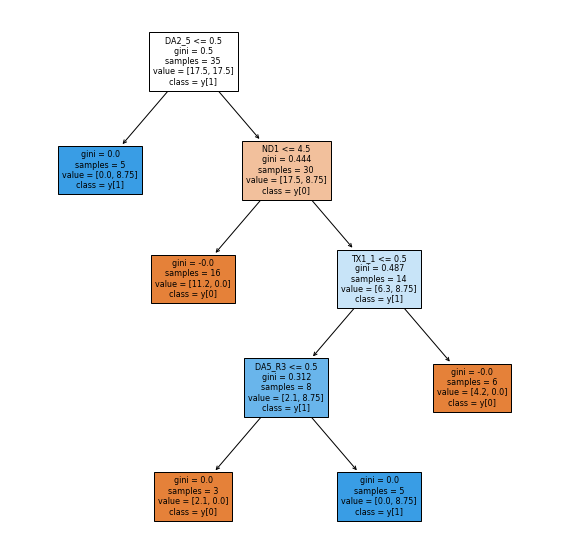

In [63]:
model = DecisionTreeClassifier(class_weight='balanced',random_state=20)

clf = model.fit(X_imp,y_tobacco)
plt.figure(figsize=(10,10))
plot_tree(clf,filled=True,fontsize=8,feature_names=list(df_C1W1nonet.columns),class_names=True)
plt.show()

Compare computational time between regular for loop (1 core) vs multiprocessing (20 cores/cpus)

We see the improvement factor is 5.

In [93]:
def decision_trees(fsubset, n_seeds):  # fsubset: subset of feature groups
    X = X_imp[:,get_f_indices(fsubset)]
    final_accs = []
    for drug, y in y_all.items():  # for each substance
        mean_acc_list = []
        for i in range(n_seeds):
            model = DecisionTreeClassifier(class_weight='balanced',
                                            max_features=X.shape[1],  # max_features = n features i.e., all
                                            splitter='best',
                                            random_state=i)
            acc = loocv(X, y, model)  # mean acc of 1 run (i.e., 1 seed) after performing LOOCV
            # print(acc)
            mean_acc_list.append(acc)

        final_accs.append( (np.mean(mean_acc_list), np.std(mean_acc_list)) )

    return (fsubset, final_accs)

In [97]:
from joblib import Parallel, delayed
import multiprocessing

# what are your inputs, and what operation do you want to
# perform on each input. For example...
inputs = list(powerset(fgroups))[1:11]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(decision_trees)(i, n_seeds=100) for i in inputs)

In [100]:
results = []
for comb in list(powerset(fgroups))[1:11]:
    results.append(decision_trees(comb, n_seeds=100))

Run on all subsets of feature groups

In [102]:
inputs = list(powerset(fgroups))[1:]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(decision_trees)(i, n_seeds=100) for i in inputs)
# format: results[i] = ( (f1,f2,f3), [(x,x), (x,x), (x,x), (x,x)] )

In [119]:
TB_dict, AL_dict, ID_dict, ND_dict = {}, {}, {}, {}
for r in results:
    TB_dict[r[0]] = r[1][0][0]
    AL_dict[r[0]] = r[1][1][0]
    ID_dict[r[0]] = r[1][2][0]
    ND_dict[r[0]] = r[1][3][0]

print(f'{max(TB_dict, key=TB_dict.get)}, {max(AL_dict, key=AL_dict.get)}, {max(ID_dict, key=ID_dict.get)}, {max(ND_dict, key=ND_dict.get)}')

('AL', 'ND', 'TX'), ('AL', 'ID', 'ND', 'AC'), ('OD', 'TX', 'CJ'), ('ID', 'OD', 'TX', 'CJ')


In [121]:
print(TB_dict[('AL', 'ND', 'TX')])
print(AL_dict[('AL', 'ID', 'ND', 'AC')])
print(ID_dict[('OD', 'TX', 'CJ')])
print(ND_dict[('ID', 'OD', 'TX', 'CJ')])

0.8688571428571429
0.7831428571428571
0.7831428571428571
0.7771428571428569


#### Random Forest

In [24]:
n_seeds = 10

for drug, y in y_all.items():
    mean_acc_list = []
    for i in range(n_seeds):
        model = RandomForestClassifier(n_estimators=100,
                                        class_weight='balanced',
                                        max_features='sqrt',  # max_features = sqrt(n_features)
                                        bootstrap=True,
                                        random_state=i)
        acc = loocv(X_imp, y, model)  # mean acc of 1 run (i.e., 1 seed) after performing LOOCV
        # print(acc)
        mean_acc_list.append(acc)


    print(f'final accuracy for {drug}: {np.mean(mean_acc_list)} +- {np.std(mean_acc_list)}')

final accuracy for tobacco: 0.7200000000000001 +- 0.011428571428571432
final accuracy for alcohol: 0.5171428571428571 +- 0.0548839220351387
final accuracy for injection: 0.6885714285714286 +- 0.020000000000000007
final accuracy for non-injection: 0.44000000000000006 +- 0.05299210568854687


In [ ]:
model = 'forest'

y = np.array([list(a) for a in zip(y_tobacco, y_alcohol, y_inj, y_noninj)])
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=42)

if model == 'logreg':
    clf = MultiOutputClassifier(LogisticRegression(solver='liblinear', penalty='l1')).fit(X_train, y_train)
elif model == 'forest':
    clf = MultiOutputClassifier(RandomForestClassifier()).fit(X_train, y_train)

predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'predictions: {predictions}')
print(f'test labels: {y_test}')
print(score)

# RocCurveDisplay.from_predictions(y_test,predictions)

predictions: [[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]
test labels: [[0 0 1 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 0 0 0]
 [0 0 1 1]
 [0 1 0 0]
 [1 0 1 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
0.18181818181818182


### PCA

In [ ]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_imp)
pca.explained_variance_ratio_

array([5.89880388e-01, 1.77891368e-01, 3.38629616e-02, 2.89192615e-02,
       2.29850290e-02, 1.59752731e-02, 1.57407439e-02, 1.14975997e-02,
       1.03707175e-02, 9.23910129e-03, 8.90749321e-03, 7.87784523e-03,
       7.11929275e-03, 7.01044225e-03, 5.93853573e-03, 5.65753912e-03,
       4.64920903e-03, 4.29160508e-03, 4.14284049e-03, 3.86177163e-03,
       3.26924060e-03, 3.10649945e-03, 2.88756061e-03, 2.40806662e-03,
       1.74972887e-03, 1.58729657e-03, 1.40023106e-03, 1.37961446e-03,
       1.34423304e-03, 1.33633933e-03, 1.10915692e-03, 1.10061010e-03,
       8.87306430e-04, 6.15097712e-04, 1.16333394e-31])

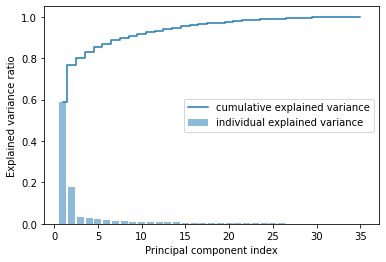

In [ ]:
plt.bar(range(1,36), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,36), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='right')
plt.show()